In [1]:
%pip install numpy yfinance matplotlib

In [2]:
import yfinance as yf

# Define the ticker symbol, for example 'AAPL' for Apple
ticker_symbol = "AAPL"

# Get the stock data
stock_data = yf.Ticker(ticker_symbol)

# Retrieve historical market data
historical_data = stock_data.history(period="max")

# Display the historical data
print(historical_data)

                                 Open        High         Low       Close  \
Date                                                                        
1980-12-12 00:00:00-05:00    0.098834    0.099264    0.098834    0.098834   
1980-12-15 00:00:00-05:00    0.094108    0.094108    0.093678    0.093678   
1980-12-16 00:00:00-05:00    0.087232    0.087232    0.086802    0.086802   
1980-12-17 00:00:00-05:00    0.088951    0.089381    0.088951    0.088951   
1980-12-18 00:00:00-05:00    0.091530    0.091959    0.091530    0.091530   
...                               ...         ...         ...         ...   
2024-12-18 00:00:00-05:00  252.160004  254.279999  247.740005  248.050003   
2024-12-19 00:00:00-05:00  247.500000  252.000000  247.089996  249.789993   
2024-12-20 00:00:00-05:00  248.039993  255.000000  245.690002  254.490005   
2024-12-23 00:00:00-05:00  254.770004  255.649994  253.449997  255.270004   
2024-12-24 00:00:00-05:00  255.490005  258.209991  255.289993  258.200012   

In [3]:
# Get Close as the data, Pad missing days with nan, interpolate nans after first non-nan, then remove trailing nans 
data = historical_data["Close"].asfreq('D').interpolate(limit=999999, limit_direction='forward').dropna()
data

Date
1980-12-12 00:00:00-05:00      0.098834
1980-12-13 00:00:00-05:00      0.097116
1980-12-14 00:00:00-05:00      0.095397
1980-12-15 00:00:00-05:00      0.093678
1980-12-16 00:00:00-05:00      0.086802
                                ...    
2024-12-20 00:00:00-05:00    254.490005
2024-12-21 00:00:00-05:00    254.750005
2024-12-22 00:00:00-05:00    255.010005
2024-12-23 00:00:00-05:00    255.270004
2024-12-24 00:00:00-05:00    258.200012
Freq: D, Name: Close, Length: 16084, dtype: float64

(24,) (6,)


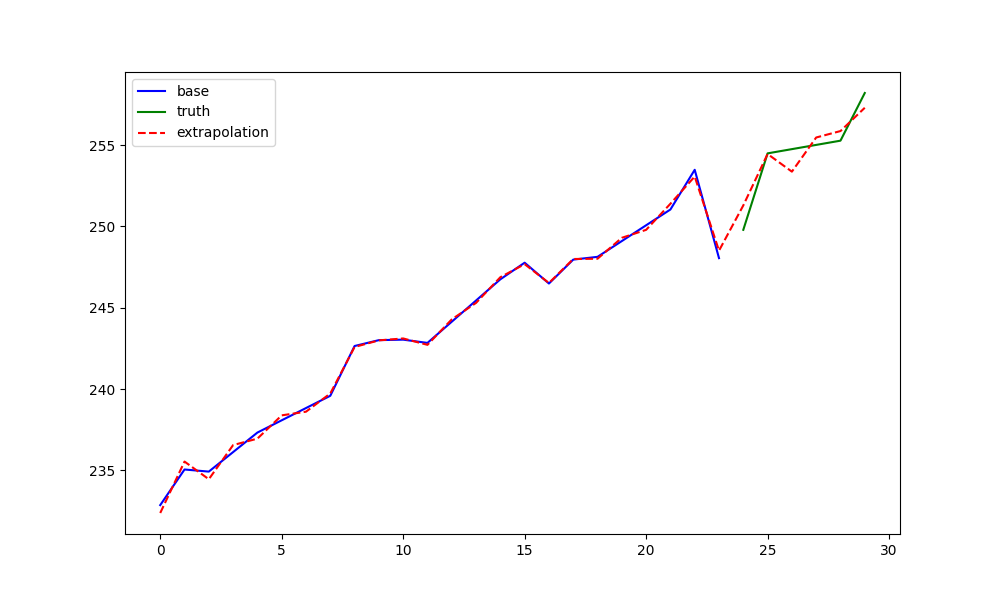

In [4]:
%matplotlib widget
import numpy as np
import pylab as pl
from numpy import fft

window_length = 30
# Get only last 30 days
data_cut = data[-window_length:].values
data_cut.shape

full_size = data_cut.size
base_size = int(data_cut.size * 0.8)

base = data_cut[:base_size]
truth = data_cut[base_size:]
print(base.shape, truth.shape)

# https://stackoverflow.com/a/28163549/17921095
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

extrapolation = fourierExtrapolation(base, truth.size)
pl.figure(figsize=(10, 6))
pl.plot(np.arange(0, base.size), base, 'b', label = 'base')
pl.plot(np.arange(base.size, full_size), truth, 'g', label = 'truth')
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation', linestyle='dashed')
pl.legend()
pl.show()

In [5]:
def calculateErrorOfWindow(window):
    data_cut = data[-window:].values
    base_size = int(data_cut.size * 0.8)
    base = data_cut[:base_size]
    truth = data_cut[base_size:]
    extrapolation = fourierExtrapolation(base, truth.size)[base_size:]

    return (np.abs(extrapolation - truth) / truth).mean() * 100

for i in range(3, 365):
    print(f'window size {i} days error rate:', calculateErrorOfWindow(i))

window size 3 days error rate: 1.034085288629092
window size 4 days error rate: 1.03408528862907
window size 5 days error rate: 1.03408528862907
window size 6 days error rate: 0.6886525384101959
window size 7 days error rate: 0.6342905025158494
window size 8 days error rate: 1.627286090552001
window size 9 days error rate: 0.2917103317427467
window size 10 days error rate: 0.38025158087106264
window size 11 days error rate: 0.42503568708349193
window size 12 days error rate: 0.46491200415173795
window size 13 days error rate: 0.5334748946769499
window size 14 days error rate: 0.5065951577106028
window size 15 days error rate: 0.5735294007914078
window size 16 days error rate: 0.8605544305256421
window size 17 days error rate: 0.808502237780365
window size 18 days error rate: 0.6471263757173492
window size 19 days error rate: 0.6717335493533391
window size 20 days error rate: 0.7399738640952452
window size 21 days error rate: 1.0206001870520913
window size 22 days error rate: 1.04375920